In [15]:
#Librairie
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization, Activation
import optuna
import tensorflow as tf
from optuna.integration import TFKerasPruningCallback



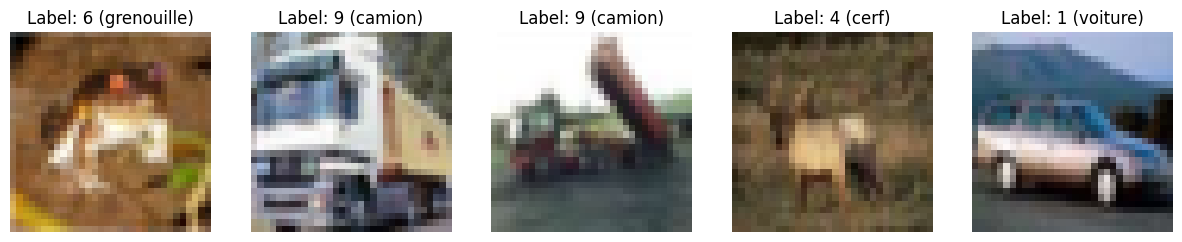

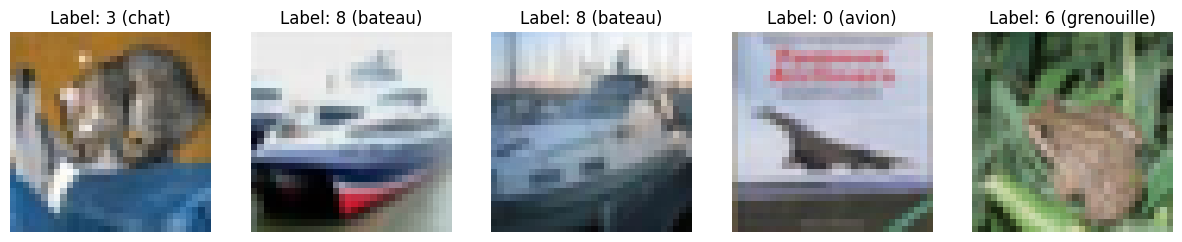

In [16]:
#Importation Dataset CIFAR-10
#Obligatoire
import tensorflow as tf

(x_train_t, y_train_t), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

#Split le data set en train et en validation (pour les CNN)

N_train_t = np.shape(x_train_t)[0]
N_train = round(0.8*N_train_t) # 80% pour le train et 20% pour la validation
x_train,y_train = x_train_t[0:N_train],y_train_t[0:N_train]
x_val,y_val = x_train_t[N_train:],y_train_t[N_train:]


#Normalisation des images

x_train, x_val, x_test = x_train / 255.0, x_val / 255.0, x_test / 255.0


cifar10_labels = ['avion', 'voiture', 'oiseau', 'chat', 'cerf', 'chien', 'grenouille', 'cheval', 'bateau', 'camion']

plt.figure(figsize=(15,3)) 
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(x_train[i])
    label_index = y_train[i][0] if isinstance(y_train[i], np.ndarray) else y_train[i]
    plt.title(f"Label: {label_index} ({cifar10_labels[label_index]})")
    plt.axis('off')
plt.show()

plt.figure(figsize=(15,3)) 
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(x_test[i])
    label_index = y_test[i][0] if isinstance(y_test[i], np.ndarray) else y_test[i]
    plt.title(f"Label: {label_index} ({cifar10_labels[label_index]})")
    plt.axis('off')
plt.show()




In [ ]:
#Algo de ML : Decision Tree 

x_train_flat = x_train_t.reshape((x_train_t.shape[0], -1))
x_test_flat = x_test.reshape((x_test.shape[0], -1))

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_flat)
x_test_scaled = scaler.transform(x_test_flat)

arbre = DecisionTreeClassifier(max_depth=10, criterion='gini', min_samples_split=20, random_state=44)
arbre.fit(x_train_scaled, y_train_t.ravel())
'''
param_grid = {
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 10, 20],
    'criterion': ['gini', 'entropy']
}

# GridSearch avec validation croisée 3-fold
grid_search = GridSearchCV(arbre, param_grid, cv=3)
grid_search.fit(x_train_scaled, y_train_t.ravel())
'''
y_pred = arbre.predict(x_test_scaled)
acc = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='macro')  # Calcul du rappel
print(f"Précision de l'arbre de décision sur CIFAR-10 : {acc:.2f}")
print(f"Rappel de l'arbre de décision sur CIFAR-10 : {recall:.2f}")

In [ ]:
#Foret Aleatoire 
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Entraînement du modèle
rf.fit(x_train_scaled, y_train_t.ravel())

# Prédiction et évaluation
y_pred = rf.predict(x_test_scaled)
acc = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='macro')  # Calcul du rappel
print(f"Précision de la forêt aléatoire sur CIFAR-10 : {acc:.2f}")
print(f"Rappel de la forêt aléatoire sur CIFAR-10 : {recall:.2f}")

Précision de la forêt aléatoire sur CIFAR-10 : 0.10
Rappel de la forêt aléatoire sur CIFAR-10 : 0.10


In [17]:
#3 CNN aux architectures différentes
#Obligatoire
# Redimensionner les images (32x32 -> 32x32x1) pour la convolution
x_train = x_train.reshape(-1, 32, 32, 3)
x_val = x_val.reshape(-1, 32, 32, 3)
x_test = x_test.reshape(-1, 32, 32, 3)
# Encodage One-Hot des labels
y_train_c = to_categorical(y_train, 10)
y_val_c = to_categorical(y_val, 10)
y_test_c = to_categorical(y_test, 10)

In [ ]:

# Optuna pour déterminer le meilleur combo epochs/batch size

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
def create_classic_cnn_model(input_shape, learning_rate):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(10, activation='softmax') 
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy','recall']
    )
    return model

def objective_cnn_classique(trial):
    # Hyperparamètres testés
    epochs = trial.suggest_int('epochs', 10, 30)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)

    tf.keras.backend.clear_session()

    model = create_classic_cnn_model(input_shape=x_train.shape[1:], learning_rate=learning_rate)

    # Callbacks
    early_stopping_optuna = EarlyStopping(
        monitor='val_accuracy', 
        patience=7,         
        restore_best_weights=True,
        mode='max'          
    )
    pruning_callback = TFKerasPruningCallback(trial, 'val_accuracy')

    print(f"\nTrial {trial.number}: epochs={epochs}, batch_size={batch_size}, lr={learning_rate:.5f}")

    # Entraîner le modèle
    history = model.fit(
        x_train, y_train_c,
        validation_data=(x_val, y_val_c),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping_optuna, pruning_callback],
        verbose=0 
    )

    
    val_accuracy = max(history.history['val_accuracy']) 
    
   
    if not history.history['val_accuracy']:
        return 0.0 

    return val_accuracy


# Le pruner aide à arrêter les essais non prometteurs plus tôt pr éviter que ce soit trop long
study_cnn_classique = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
study_cnn_classique.optimize(objective_cnn_classique, n_trials=20) 

print("\nOptimisation terminée.")
print("Meilleurs hyperparamètres trouvés pour le CNN classique: ", study_cnn_classique.best_params)
print("Meilleure val_accuracy obtenue : ", study_cnn_classique.best_value)


best_params_cnn_classique = study_cnn_classique.best_params


In [18]:
#CNN classique (comme dans le TD)
model = Sequential([
Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3)), # Couche Conv
MaxPooling2D(2,2), # Max Pooling
Conv2D(64, (3,3), activation='relu'), # Deuxième Couche Conv
MaxPooling2D(2,2),
Flatten(), # Aplatit les données
Dense(128, activation='relu'), # Couche Fully Connected
Dense(10, activation='softmax') # Couche de sortie (10 classes)
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy','recall'])
model.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

c:\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 315,722 (1.20 MB)

 Trainable params: 315,722 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
#CNN un peu plus complexe (une couche de convolution en + et ajout de dropout)

model_2 = Sequential([
    Conv2D(32, (5,5), padding='same',activation='relu', input_shape=(32,32,3)),
    BatchNormalization(),
    Conv2D(32, (5,5), padding='same',activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.3),

    Conv2D(64, (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3,3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.3),

    Conv2D(128, (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    Conv2D(128, (3,3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.3),

    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)), 
    Dropout(0.5),
    Dense(10, activation='softmax')
])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'recall'])
model_2.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 32, 32, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 32, 32, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 832,938 (3.18 MB)

 Trainable params: 832,490 (3.18 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
#Modèle basé sur le MCDNN https://arxiv.org/pdf/1202.2745v1 
#Si ça overfit rajoute du dropout

model_3 = Sequential([
    Conv2D(300, (3, 3), padding='same', input_shape=(32, 32, 3)), 
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),  

    Conv2D(300, (2, 2), padding='same'), 
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(300, (2, 2), padding='same'), 
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
   

    Conv2D(300, (2, 2), padding='same'), 
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25), 

    Flatten(), 
    Dense(300), 
    BatchNormalization(),
    Activation('relu'),
    

    Dense(100), 
    BatchNormalization(),
    Activation('relu'),
    

    Dense(10, activation='softmax')  
])


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy','recall'])
model_3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 30, 30, 300)    │         8,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 15, 15, 300)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 15, 15, 300)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 14, 14, 300)    │       360,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 7, 7, 300)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 7, 7, 300)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 6, 300)      │       360,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 3, 3, 300)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 2, 2, 300)      │       360,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 1, 1, 300)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1, 1, 300)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 300)            │        90,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,210,710 (4.62 MB)

 Trainable params: 1,210,710 (4.62 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/22
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.3487 - loss: 1.7841 - recall: 0.1068 - val_accuracy: 0.5182 - val_loss: 1.3611 - val_recall: 0.3041
Epoch 2/22
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5690 - loss: 1.2267 - recall: 0.3759 - val_accuracy: 0.5806 - val_loss: 1.2370 - val_recall: 0.4271
Epoch 3/22
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6326 - loss: 1.0554 - recall: 0.4782 - val_accuracy: 0.6285 - val_loss: 1.0657 - val_recall: 0.4742
Epoch 4/22
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6677 - loss: 0.9518 - recall: 0.5353 - val_accuracy: 0.6535 - val_loss: 0.9966 - val_recall: 0.5187
Epoch 5/22
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6984 - loss: 0.8781 - recall: 0.5842 - val_accuracy: 0.6628 - val_loss: 0.9727 - val_recall: 0.5608
Epoch 6/22
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7177 - loss: 0.8129 - recall: 0.6167 - val_accuracy: 0.6828 - val_loss: 0.9342 - val_recall: 0.5864
Epoc

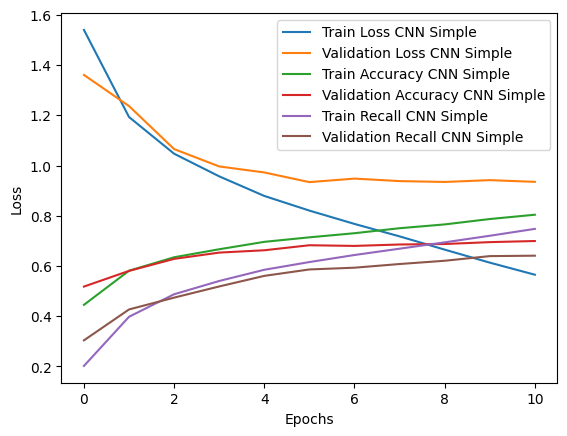

In [20]:
# Entraînement du 1er model
history_1 = model.fit(
    x_train, y_train_c,
    validation_data=(x_val, y_val_c),
    epochs=22,
    batch_size=64,
    callbacks=[early_stopping]
)

plt.plot(history_1.history['loss'], label='Train Loss CNN Simple')
plt.plot(history_1.history['val_loss'], label='Validation Loss CNN Simple')
plt.plot(history_1.history['accuracy'], label='Train Accuracy CNN Simple')
plt.plot(history_1.history['val_accuracy'], label='Validation Accuracy CNN Simple')
plt.plot(history_1.history['recall'], label='Train Recall CNN Simple')
plt.plot(history_1.history['val_recall'], label='Validation Recall CNN Simple')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


In [ ]:
# Entraînement model_2
history_intermediate = model_2.fit(
    x_train, y_train_c,
    validation_data=(x_val, y_val_c),
    epochs=22,
    batch_size=64,
    callbacks=[early_stopping]
)
plt.plot(history_intermediate.history['loss'], label='Train Loss CNN Inter')
plt.plot(history_intermediate.history['val_loss'], label='Validation Loss CNN Inter')
plt.plot(history_intermediate.history['accuracy'], label='Train Accuracy CNN Inter')
plt.plot(history_intermediate.history['val_accuracy'], label='Validation Accuracy CNN Inter')
plt.plot(history_intermediate.history['recall'], label='Train Recall CNN Inter')
plt.plot(history_intermediate.history['val_recall'], label='Validation Recall CNN Inter')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

Epoch 1/22
625/625 ━━━━━━━━━━━━━━━━━━━━ 417s 661ms/step - accuracy: 0.2375 - loss: 2.1551 - recall: 0.0400 - val_accuracy: 0.3415 - val_loss: 1.8406 - val_recall: 0.1486
Epoch 2/22
625/625 ━━━━━━━━━━━━━━━━━━━━ 620s 991ms/step - accuracy: 0.4316 - loss: 1.5451 - recall: 0.2035 - val_accuracy: 0.5444 - val_loss: 1.2697 - val_recall: 0.3446
Epoch 3/22
625/625 ━━━━━━━━━━━━━━━━━━━━ 405s 647ms/step - accuracy: 0.5540 - loss: 1.2710 - recall: 0.3621 - val_accuracy: 0.5763 - val_loss: 1.2134 - val_recall: 0.4684
Epoch 4/22
625/625 ━━━━━━━━━━━━━━━━━━━━ 357s 571ms/step - accuracy: 0.6303 - loss: 1.0764 - recall: 0.4817 - val_accuracy: 0.6275 - val_loss: 1.1367 - val_recall: 0.5349
Epoch 5/22
625/625 ━━━━━━━━━━━━━━━━━━━━ 382s 611ms/step - accuracy: 0.6784 - loss: 0.9394 - recall: 0.5538 - val_accuracy: 0.7167 - val_loss: 0.8021 - val_recall: 0.6105
Epoch 6/22
625/625 ━━━━━━━━━━━━━━━━━━━━ 407s 651ms/step - accuracy: 0.7138 - loss: 0.8424 - recall: 0.6025 - val_accuracy: 0.7052 - val_loss: 0.9006 -

In [ ]:

# Entraînement du MCDNN
history_deep = model_3.fit(
    x_train, y_train_c,
    validation_data=(x_val, y_val_c),
    epochs=22,
    batch_size=64,
    callbacks=[early_stopping]
)
plt.plot(history_deep.history['loss'], label='Train Loss MCDNN')
plt.plot(history_deep.history['val_loss'], label='Validation Loss MCDNN')
plt.plot(history_deep.history['accuracy'], label='Train Accuracy MCDNN')
plt.plot(history_deep.history['val_accuracy'], label='Validation Accuracy MCDNN')
plt.plot(history_deep.history['recall'], label='Train Recall MCDNN')
plt.plot(history_deep.history['val_recall'], label='Train Recall MCDNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

NameError: name 'model_3' is not defined

In [ ]:
#Evaluation du 1er modèle
model_names_single = ["CNN Classique (model)"]
models_to_evaluate_single = [model] 

results_single = []

print("Évaluation du modèle CNN Classique en cours...")

for i, current_model in enumerate(models_to_evaluate_single):
    model_name = model_names_single[i]
    print(f"Évaluation de : {model_name}")

    train_loss, train_accuracy, train_recall = current_model.evaluate(x_train, y_train_c, verbose=0)
    results_single.append({
        "Modèle": model_name,
        "Set": "Train",
        "Loss": f"{train_loss:.4f}",
        "Accuracy": f"{train_accuracy:.4f}",
        "Recall": f"{train_recall:.4f}"
    })

    val_loss, val_accuracy, val_recall = current_model.evaluate(x_val, y_val_c, verbose=0)
    results_single.append({
        "Modèle": model_name,
        "Set": "Validation",
        "Loss": f"{val_loss:.4f}",
        "Accuracy": f"{val_accuracy:.4f}",
        "Recall": f"{val_recall:.4f}"
    })


    test_loss, test_accuracy, test_recall = current_model.evaluate(x_test, y_test_c, verbose=0)
    results_single.append({
        "Modèle": model_name,
        "Set": "Test",
        "Loss": f"{test_loss:.4f}",
        "Accuracy": f"{test_accuracy:.4f}",
        "Recall": f"{test_recall:.4f}"
    })


df_results_single = pd.DataFrame(results_single)

print("\n\nTableau Récapitulatif des Performances (CNN Classique):\n")
print(df_results_single.to_markdown(index=False))



Évaluation du modèle CNN Classique en cours...
Évaluation de : CNN Classique (model)


Tableau Récapitulatif des Performances (CNN Classique):

| Modèle                | Set        |   Loss |   Accuracy |   Recall |
|:----------------------|:-----------|-------:|-----------:|---------:|
| CNN Classique (model) | Train      | 0.4982 |     0.8347 |   0.7674 |
| CNN Classique (model) | Validation | 0.8714 |     0.7086 |   0.6434 |
| CNN Classique (model) | Test       | 0.8893 |     0.7042 |   0.6395 |


In [10]:
#Evaluation du 2ème modèle
model_names_single = ["CNN Intermédiaire"]
models_to_evaluate_single = [model_2] 

results_single = []

print("Évaluation du modèle CNN Classique en cours...")

for i, current_model in enumerate(models_to_evaluate_single):
    model_name = model_names_single[i]
    print(f"Évaluation de : {model_name}")

    
    train_loss, train_accuracy, train_recall = current_model.evaluate(x_train, y_train_c, verbose=0)
    results_single.append({
        "Modèle": model_name,
        "Set": "Train",
        "Loss": f"{train_loss:.4f}",
        "Accuracy": f"{train_accuracy:.4f}",
        "Recall": f"{train_recall:.4f}"
    })

    
    val_loss, val_accuracy, val_recall = current_model.evaluate(x_val, y_val_c, verbose=0)
    results_single.append({
        "Modèle": model_name,
        "Set": "Validation",
        "Loss": f"{val_loss:.4f}",
        "Accuracy": f"{val_accuracy:.4f}",
        "Recall": f"{val_recall:.4f}"
    })

    
    test_loss, test_accuracy, test_recall = current_model.evaluate(x_test, y_test_c, verbose=0)
    results_single.append({
        "Modèle": model_name,
        "Set": "Test",
        "Loss": f"{test_loss:.4f}",
        "Accuracy": f"{test_accuracy:.4f}",
        "Recall": f"{test_recall:.4f}"
    })


df_results_single = pd.DataFrame(results_single)

print("\n\nTableau Récapitulatif des Performances (CNN Intermédiaire):\n")
print(df_results_single.to_markdown(index=False))



Évaluation du modèle CNN Classique en cours...
Évaluation de : CNN Intermédiaire


Tableau Récapitulatif des Performances (CNN Intermédiaire):

| Modèle            | Set        |   Loss |   Accuracy |   Recall |
|:------------------|:-----------|-------:|-----------:|---------:|
| CNN Intermédiaire | Train      | 0.5245 |     0.8256 |   0.7406 |
| CNN Intermédiaire | Validation | 0.789  |     0.7243 |   0.6455 |
| CNN Intermédiaire | Test       | 0.8179 |     0.717  |   0.635  |


In [ ]:
#Evaluation du 3ème modèle
model_names_single = ["MCDNN"]
models_to_evaluate_single = [model_3] 

results_single = []

print("Évaluation du modèle CNN Classique en cours...")

for i, current_model in enumerate(models_to_evaluate_single):
    model_name = model_names_single[i]
    print(f"Évaluation de : {model_name}")

    
    train_loss, train_accuracy, train_recall = current_model.evaluate(x_train, y_train_c, verbose=0)
    results_single.append({
        "Modèle": model_name,
        "Set": "Train",
        "Loss": f"{train_loss:.4f}",
        "Accuracy": f"{train_accuracy:.4f}",
        "Recall": f"{train_recall:.4f}"
    })

    
    val_loss, val_accuracy, val_recall = current_model.evaluate(x_val, y_val_c, verbose=0)
    results_single.append({
        "Modèle": model_name,
        "Set": "Validation",
        "Loss": f"{val_loss:.4f}",
        "Accuracy": f"{val_accuracy:.4f}",
        "Recall": f"{val_recall:.4f}"
    })

    
    test_loss, test_accuracy, test_recall = current_model.evaluate(x_test, y_test_c, verbose=0)
    results_single.append({
        "Modèle": model_name,
        "Set": "Test",
        "Loss": f"{test_loss:.4f}",
        "Accuracy": f"{test_accuracy:.4f}",
        "Recall": f"{test_recall:.4f}"
    })


df_results_single = pd.DataFrame(results_single)

print("\n\nTableau Récapitulatif des Performances (MCDNN):\n")
print(df_results_single.to_markdown(index=False))



In [ ]:
#CNN hybride avec ResNet + SVM (entrainement, )
from sklearn.svm import SVC
from tensorflow.keras.applications import ResNet50V2
#from tensorflow.image import resize pas besoin de resize car les images sont déjà en 32x32 avec ResNet

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

x_train, x_test = x_train / 255.0, x_test / 255.0

base_model = ResNet50V2(weights="imagenet", include_top=False, input_shape=(32, 32, 3))
for layer in base_model.layers:
    layer.trainable = False


x_train_extraite = base_model.predict(x_train, verbose=1)
x_test_extraite= base_model.predict(x_test, verbose=1)


features_train_flat = x_train_extraite.reshape(x_train_extraite.shape[0], -1)
features_test_flat = x_test_extraite.reshape(x_test_extraite.shape[0], -1)

scaler = StandardScaler()
features_train_flat = scaler.fit_transform(features_train_flat)
features_test_flat = scaler.transform(features_test_flat)

print("Entraînement du SVM...")
svm= SVC(kernel='linear', C=1, random_state=42)
svm.fit(features_train_flat, y_train.ravel())

y_pred_test = svm.predict(features_test_flat)
y_true_test = y_test.ravel() # Utiliser y_test (10k échantillons)

# Prédictions sur l'ensemble d'entraînement
print("Prédictions sur les données d'entraînement...")
y_pred_train = svm.predict(features_train_flat)
y_true_train = y_train.ravel() # Utiliser y_train (50k échantillons)

# Calculer les métriques pour l'ensemble de test
acc_test = accuracy_score(y_true_test, y_pred_test)
recall_test = recall_score(y_true_test, y_pred_test, average='macro')

# Calculer les métriques pour l'ensemble d'entraînement
acc_train = accuracy_score(y_true_train, y_pred_train)
recall_train = recall_score(y_true_train, y_pred_train, average='macro')

# Stocker les résultats
results_hybrid = []
results_hybrid.append({
    "Modèle": "ResNet50V2+SVM",
    "Set": "Train",
    "Accuracy": f"{acc_train:.4f}",
    "Recall": f"{recall_train:.4f}"
})
results_hybrid.append({
    "Modèle": "ResNet50V2+SVM",
    "Set": "Test",
    "Accuracy": f"{acc_test:.4f}",
    "Recall": f"{recall_test:.4f}"
})

# Créer un DataFrame et afficher le tableau
df_results_hybrid = pd.DataFrame(results_hybrid)
print("\n\nTableau Récapitulatif des Performances (ResNet50V2+SVM):\n")
print(df_results_hybrid.to_markdown(index=False))

# Afficher la matrice de confusion pour l'ensemble de test
print("\nMatrice de confusion (Ensemble de Test):")
print(confusion_matrix(y_true_test, y_pred_test))


    

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 467s 295ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 102s 326ms/step
Entraînement du SVM...


Création du modèle ResNet20 extracteur de caractéristiques...

Architecture de l'extracteur de caractéristiques ResNet20:


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_35 (Conv2D)  │ (None, 32, 32,    │        448 │ input_layer_8[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │         64 │ conv2d_35[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_16       │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res2a_branch2a      │ (None, 32, 32,    │      2,320 │ activation_16[0]… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn2a_branch2a       │ (None, 32, 32,    │         64 │ res2a_branch2a[0… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 32, 32,    │          0 │ bn2a_branch2a[0]… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res2a_branch2b      │ (None, 32, 32,    │      2,320 │ activation_17[0]… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn2a_branch2b       │ (None, 32, 32,    │         64 │ res2a_branch2b[0… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 32, 32,    │          0 │ bn2a_branch2b[0]… │
│                     │ 16)               │            │ activation_16[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 32, 32,    │          0 │ add_6[0][0]       │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res2b_branch2a      │ (None, 32, 32,    │      2,320 │ activation_18[0]… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn2b_branch2a       │ (None, 32, 32,    │         64 │ res2b_branch2a[0… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_19       │ (None, 32, 32,    │          0 │ bn2b_branch2a[0]… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res2b_branch2b      │ (None, 32, 32,    │      2,320 │ activation_19[0]… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn2b_branch2b       │ (None, 32, 32,    │         64 │ res2b_branch2b[0… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 32, 32,    │          0 │ bn2b_branch2b[0]

 Total params: 274,176 (1.05 MB)

 Trainable params: 272,608 (1.04 MB)

 Non-trainable params: 1,568 (6.12 KB)


Extraction des caractéristiques avec ResNet20...
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 26s 16ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
Shape des caractéristiques d'entraînement: (50000, 64)
Shape des caractéristiques de test: (10000, 64)

Entraînement du SVM avec noyau RBF...
[LibSVM]
Prédictions sur les données de test...
Prédictions sur les données d'entraînement...


Tableau Récapitulatif des Performances (ResNet20+SVM):

| Modèle            | Set   |   Accuracy |   Recall |
|:------------------|:------|-----------:|---------:|
| ResNet20+SVM(RBF) | Train |     0.592  |   0.592  |
| ResNet20+SVM(RBF) | Test  |     0.4597 |   0.4597 |

Matrice de confusion (Ensemble de Test):
[[564  54  59  26  28  18  19  35 138  59]
 [ 51 560  19  41  12  26  27  33  75 156]
 [ 94  35 341  88 136  63 123  73  25  22]
 [ 40  54  96 261  61 169 146  83  35  55]
 [ 57  31 138  59 356  47 168  93  28  23]
 [ 24  40  91 158  58 389  82 102  28  28]
 [ 11  35  83  72  96  59 564  47  12  21]
 [ 49  43 

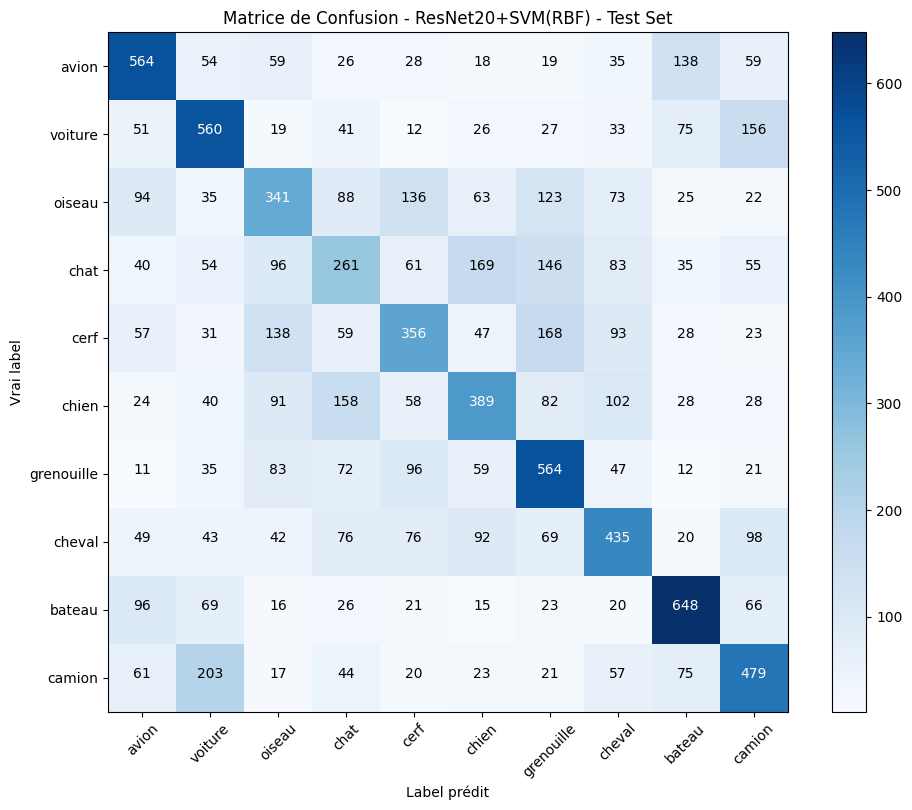

In [ ]:
#Réseau hybride ResNet20 entraîné + SVM adapté pour CIFAR-10
from sklearn.svm import SVC
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, AveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def resnet_layer(inputs, num_filters=16, kernel_size=3, strides=1, activation='relu', batch_normalization=True, conv_first=True):
    """Couche de base pour ResNet."""
    conv = Conv2D(num_filters, kernel_size=kernel_size, strides=strides, padding='same',
                  kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))
    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

def resnet_v1_block(inputs, num_filters, strides, stage, block_char):
    """Un bloc résiduel ResNet v1."""
    conv_name_base = f'res{stage}{block_char}_branch'
    bn_name_base = f'bn{stage}{block_char}_branch'

    # Chemin principal
    x = Conv2D(num_filters, kernel_size=3, strides=strides, padding='same',
               name=conv_name_base + '2a', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(inputs)
    x = BatchNormalization(name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters, kernel_size=3, padding='same',
               name=conv_name_base + '2b', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization(name=bn_name_base + '2b')(x)

    # Chemin de la connexion résiduelle (shortcut)
    shortcut = inputs
    if strides > 1 or shortcut.shape[-1] != num_filters:
        shortcut = Conv2D(num_filters, kernel_size=1, strides=strides, padding='same',
                          name=conv_name_base + '1', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(inputs)
        shortcut = BatchNormalization(name=bn_name_base + '1')(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def create_resnet20_full_model(input_shape=(32, 32, 3), num_classes=10):
    """Crée un modèle ResNet20 complet pour CIFAR-10."""
    inputs = Input(shape=input_shape)
    num_filters = 16
    num_blocks = 3  # Pour ResNet20, n=3 (20 = 6n + 2)

    # Couche initiale
    x = resnet_layer(inputs=inputs, num_filters=num_filters)

    # Blocs résiduels
    for stage in range(3):  # 3 stages de blocs
        for res_block in range(num_blocks):
            strides = 1
            if stage > 0 and res_block == 0:  # Downsample au début de chaque stage (sauf le premier)
                strides = 2
            
            block_char = chr(ord('a') + res_block)
            x = resnet_v1_block(inputs=x,
                                num_filters=num_filters * (2**stage),  # Augmente le nombre de filtres
                                strides=strides,
                                stage=stage + 2,  # Convention de nommage (stage 2, 3, 4)
                                block_char=block_char)
    
    # Couches finales
    x = AveragePooling2D(pool_size=8)(x)
    x = Flatten()(x)
    outputs = Dense(num_classes, activation='softmax', kernel_initializer='he_normal')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Rechargement des données CIFAR-10
(x_train_hybrid, y_train_hybrid), (x_test_hybrid, y_test_hybrid) = tf.keras.datasets.cifar10.load_data()

# Normalisation des images
x_train_hybrid_norm = x_train_hybrid / 255.0
x_test_hybrid_norm = x_test_hybrid / 255.0

# Split pour validation
N_train_hybrid = int(0.8 * len(x_train_hybrid_norm))
x_train_res = x_train_hybrid_norm[:N_train_hybrid]
y_train_res = y_train_hybrid[:N_train_hybrid]
x_val_res = x_train_hybrid_norm[N_train_hybrid:]
y_val_res = y_train_hybrid[N_train_hybrid:]

# Encodage one-hot pour l'entraînement
y_train_res_cat = to_categorical(y_train_res, 10)
y_val_res_cat = to_categorical(y_val_res, 10)

print("ÉTAPE 1: Entraînement du ResNet20 complet sur CIFAR-10...")
resnet20_model = create_resnet20_full_model()

resnet20_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks pour l'entraînement
early_stopping_resnet = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True, mode='max')
reduce_lr_resnet = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Entraînement du ResNet20 (modèle complet)
print("Entraînement en cours... (cela peut prendre du temps)")
history_resnet = resnet20_model.fit(
    x_train_res, y_train_res_cat,
    validation_data=(x_val_res, y_val_res_cat),
    epochs=80,  # Plus d'époques pour un bon entraînement
    batch_size=32,
    callbacks=[early_stopping_resnet, reduce_lr_resnet],
    verbose=1
)

print(f"Meilleure accuracy de validation: {max(history_resnet.history['val_accuracy']):.4f}")

print("\nÉTAPE 2: Création de l'extracteur de caractéristiques à partir du modèle entraîné...")
# Créer l'extracteur de caractéristiques en retirant la couche Dense finale
feature_extractor = Model(
    inputs=resnet20_model.input,
    outputs=resnet20_model.layers[-2].output  # Avant la couche Dense finale
)

print("Extraction des caractéristiques avec le ResNet20 entraîné...")
features_train = feature_extractor.predict(x_train_hybrid_norm, verbose=1)
features_test = feature_extractor.predict(x_test_hybrid_norm, verbose=1)

print(f"Shape des caractéristiques d'entraînement: {features_train.shape}")
print(f"Shape des caractéristiques de test: {features_test.shape}")

# Normalisation des caractéristiques
scaler = StandardScaler()
features_train_scaled = scaler.fit_transform(features_train)
features_test_scaled = scaler.transform(features_test)

print("\nÉTAPE 3: Entraînement du SVM avec les caractéristiques extraites...")
# Test de différents noyaux SVM
svm_configs = [
    {'kernel': 'rbf', 'C': 1.0, 'gamma': 'scale'},
    {'kernel': 'rbf', 'C': 10.0, 'gamma': 'scale'},
    {'kernel': 'linear', 'C': 1.0},
    {'kernel': 'poly', 'degree': 3, 'C': 1.0, 'gamma': 'scale'}
]

best_acc = 0
best_config = None
best_svm = None

for config in svm_configs:
    print(f"\nTest SVM avec config: {config}")
    svm_classifier = SVC(random_state=42, **config)
    svm_classifier.fit(features_train_scaled, y_train_hybrid.ravel())
    
    # Test rapide sur un échantillon
    y_pred_sample = svm_classifier.predict(features_test_scaled[:1000])
    acc_sample = accuracy_score(y_test_hybrid[:1000].ravel(), y_pred_sample)
    print(f"Accuracy sur échantillon test (1000 exemples): {acc_sample:.4f}")
    
    if acc_sample > best_acc:
        best_acc = acc_sample
        best_config = config
        best_svm = svm_classifier

print(f"\nMeilleure configuration SVM: {best_config}")
print("Évaluation finale avec le meilleur SVM...")

# Prédictions finales avec le meilleur modèle
y_pred_test_hybrid = best_svm.predict(features_test_scaled)
y_true_test_hybrid = y_test_hybrid.ravel()

y_pred_train_hybrid = best_svm.predict(features_train_scaled)
y_true_train_hybrid = y_train_hybrid.ravel()

# Calculer les métriques
acc_test_hybrid = accuracy_score(y_true_test_hybrid, y_pred_test_hybrid)
recall_test_hybrid = recall_score(y_true_test_hybrid, y_pred_test_hybrid, average='macro', zero_division=0)

acc_train_hybrid = accuracy_score(y_true_train_hybrid, y_pred_train_hybrid)
recall_train_hybrid = recall_score(y_true_train_hybrid, y_pred_train_hybrid, average='macro', zero_division=0)

# Stocker les résultats
results_hybrid = []
results_hybrid.append({
    "Modèle": "ResNet20(entraîné)+SVM",
    "Set": "Train",
    "Accuracy": f"{acc_train_hybrid:.4f}",
    "Recall": f"{recall_train_hybrid:.4f}"
})
results_hybrid.append({
    "Modèle": "ResNet20(entraîné)+SVM",
    "Set": "Test",
    "Accuracy": f"{acc_test_hybrid:.4f}",
    "Recall": f"{recall_test_hybrid:.4f}"
})

# Créer un DataFrame et afficher le tableau
df_results_hybrid = pd.DataFrame(results_hybrid)
print("\n\nTableau Récapitulatif des Performances (ResNet20 entraîné + SVM):\n")
print(df_results_hybrid.to_markdown(index=False))

# Afficher la matrice de confusion pour l'ensemble de test
print("\nMatrice de confusion (Ensemble de Test):")
cm_test_hybrid = confusion_matrix(y_true_test_hybrid, y_pred_test_hybrid)
print(cm_test_hybrid)

# Visualisation de la matrice de confusion
plt.figure(figsize=(10, 8))
plt.imshow(cm_test_hybrid, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matrice de Confusion - ResNet20(entraîné)+SVM - Test Set')
plt.colorbar()
tick_marks = np.arange(len(cifar10_labels))
plt.xticks(tick_marks, cifar10_labels, rotation=45)
plt.yticks(tick_marks, cifar10_labels)
plt.tight_layout()
plt.ylabel('Vrai label')
plt.xlabel('Label prédit')

# Ajouter les valeurs dans les cellules
thresh = cm_test_hybrid.max() / 2.
for i, j in np.ndindex(cm_test_hybrid.shape):
    plt.text(j, i, format(cm_test_hybrid[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm_test_hybrid[i, j] > thresh else "black")

plt.show()

print(f"\nRésumé:")
print(f"ResNet20 seul (accuracy validation): {max(history_resnet.history['val_accuracy']):.4f}")
print(f"ResNet20+SVM (accuracy test): {acc_test_hybrid:.4f}")